In [1]:
import sys
import os
sys.path.append('..')


# Load model

In [2]:
import torch
from comic_ocr.models import recognition
from comic_ocr.utils import get_path_project_dir
from comic_ocr.utils.pytorch_model import get_total_parameters_count
from comic_ocr.models.recognition.crnn.crnn import CRNN


model_name = 'recognition_crnn_small'
model_path = get_path_project_dir(f'data/output/models/{model_name}.bin')

model = CRNN.create_small_model()
# model = recognition.load_model(model_path)

In [3]:
print('- preferred_image_size:', model.preferred_image_height)
print('- get_total_parameters_count', get_total_parameters_count(model))


- preferred_image_size: 24
- get_total_parameters_count 482001


# Prepare Dataset

In [4]:
from comic_ocr.utils.ploting import show_images

dataset_example 40


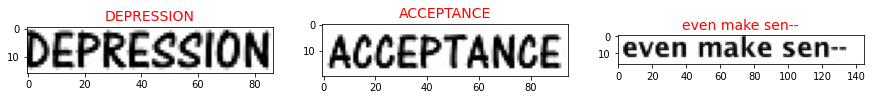

In [5]:
dataset_example_path = get_path_project_dir('example/manga_annotated')
dataset_example = recognition.RecognitionDataset.load_annotated_dataset(dataset_example_path)
print('dataset_example', len(dataset_example))

show_images(
    [dataset_example.get_line_image(0), dataset_example.get_line_image(1), dataset_example.get_line_image(-1)],
    [dataset_example.get_line_text(0), dataset_example.get_line_text(1), dataset_example.get_line_text(-1)],
) 

generated_dataset 4658


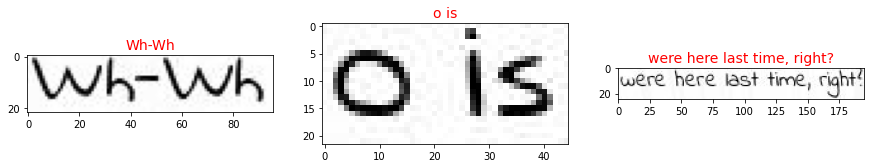

In [6]:
dataset_generated_path = get_path_project_dir('data/output/generate_manga_dataset')
dataset_generated = recognition.RecognitionDataset.load_generated_dataset(dataset_generated_path)
print('generated_dataset', len(dataset_generated))


show_images(
    [dataset_generated.get_line_image(0), dataset_generated.get_line_image(1), dataset_generated.get_line_image(-1)],
    [dataset_generated.get_line_text(0), dataset_generated.get_line_text(1), dataset_generated.get_line_text(-1)],
) 

dataset_annotated 446


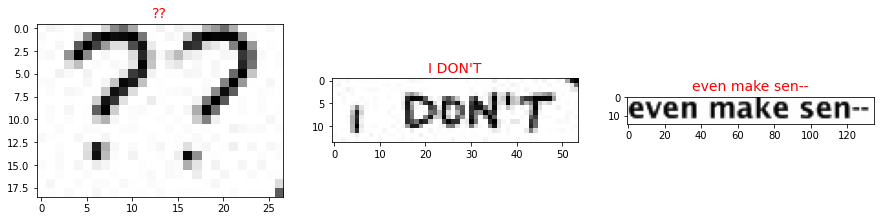

In [7]:
dataset_annotated_path = get_path_project_dir('data/manga_line_annotated')
dataset_annotated = recognition.RecognitionDataset.load_annotated_dataset(dataset_annotated_path)
print('dataset_annotated', len(dataset_annotated))

show_images(
    [dataset_annotated.get_line_image(0), dataset_annotated.get_line_image(1), dataset_annotated.get_line_image(-1)],
    [dataset_annotated.get_line_text(0), dataset_annotated.get_line_text(1), dataset_annotated.get_line_text(-1)],
) 

## Train/Validation Datasets

In [8]:
import random
random.seed('abdc')

dataset_annotated = dataset_annotated.shuffle()
dataset_generated = dataset_generated.shuffle()
dataset_example = dataset_example.shuffle()

# Validation Dataset (annotated + example)
validation_dataset = recognition.RecognitionDataset.merge(
    dataset_example,
    dataset_annotated.subset(to_idx=200)
).shuffle()


# Training Dataset (generated + annotated + example)
training_dataset = recognition.RecognitionDataset.merge(
    dataset_annotated.subset(from_idx=200).repeat(10),
    dataset_generated.subset(from_idx=0, to_idx=3000),
)
training_dataset = recognition.RecognitionDataset.merge(
    training_dataset,
    dataset_example.repeat(20)
)

training_dataset = recognition.RecognitionDatasetWithAugmentation.of_dataset(training_dataset, batch_height=model.preferred_image_height)


print('validation_dataset', len(validation_dataset))
print('training_dataset', len(training_dataset))

validation_dataset 240
training_dataset 6260


# Training

In [9]:
from comic_ocr.models import train_helpers
from comic_ocr.models.recognition import train
from comic_ocr.utils.ploting import plot_losses, plot_metrics, show_images
from torch import optim
from IPython.display import clear_output

device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')



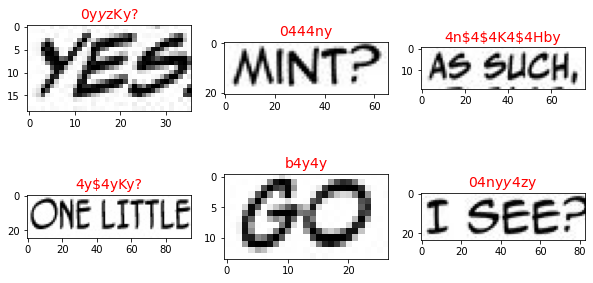

In [10]:

def show_example(model, images):
    outputs = [model.recognize(img, device=device) for img in images]
    show_images(images, outputs, figsize=(10, 5))

    
show_example(model, [
    validation_dataset.get_line_image(0), 
    validation_dataset.get_line_image(1), 
    validation_dataset.get_line_image(-1),
    training_dataset.get_line_image(0), 
    training_dataset.get_line_image(1), 
    training_dataset.get_line_image(-1)
])

In [11]:
def save_and_report(step, train_metrics, validate_metrics):
    clear_output()
    plot_metrics(metrics=[
        ('Training Losses', train_metrics['loss']),
        ('Validation Losses', validate_metrics['loss']),
        ('Accuracy (Perfect Match)', validate_metrics['perfect_match_accuracy']),
    ], num_col=2, figsize=(10, 5))
    show_example(model, [
        validation_dataset.get_line_image(0), 
        validation_dataset.get_line_image(1), 
        validation_dataset.get_line_image(-1),
        training_dataset.get_line_image(0), 
        training_dataset.get_line_image(1), 
        training_dataset.get_line_image(-1)
    ])
    
    torch.save(model, model_path)

<Figure size 720x360 with 0 Axes>

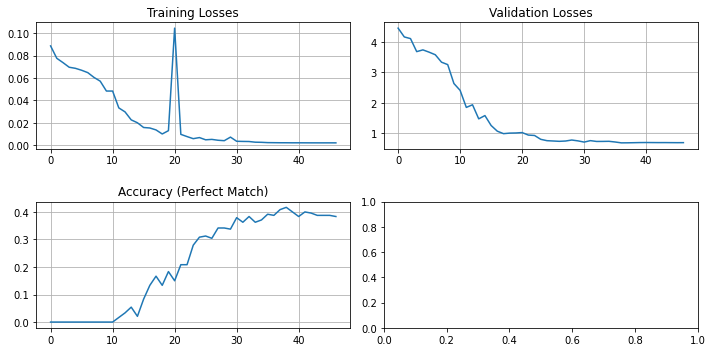

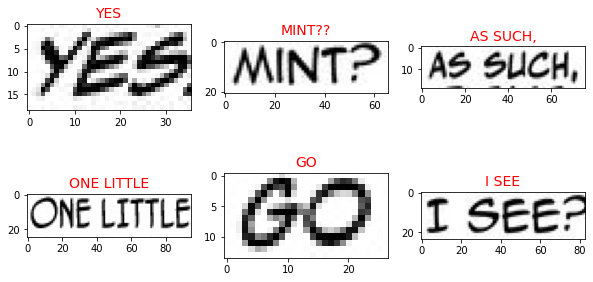

Epoch 14: 100%|██████████| 6260/6260 [00:08<00:00, 754.35it/s, current_batch_loss=0.05]   


In [12]:
#validation_dataset = validation_dataset.subset(to_idx=10)
#training_dataset = training_dataset.subset(to_idx=50)

_ = train.train(
    model_name, model,
    train_dataset=training_dataset,
    train_device=device,
    validate_dataset=validation_dataset,
    validate_device=device,
    update_callback=save_and_report,
    update_every_n=40,
    batch_size=50,
    train_epoch_count=15)

<Figure size 720x360 with 0 Axes>

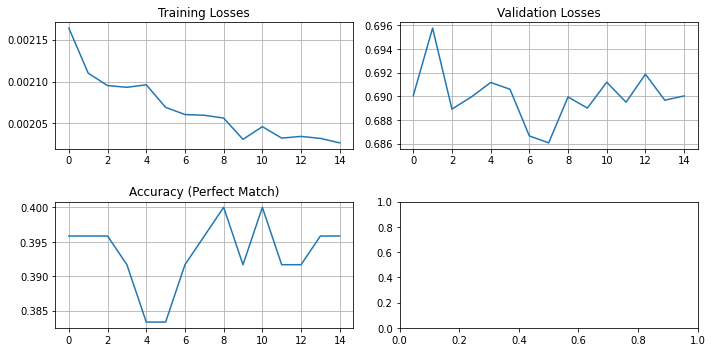

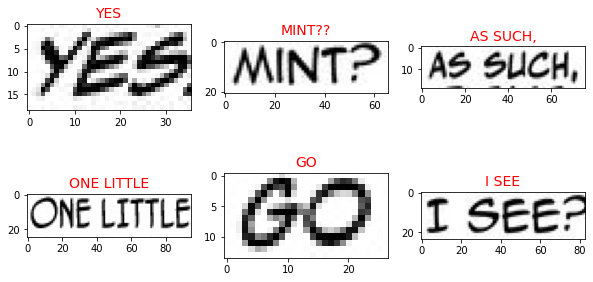

Epoch 4: 100%|██████████| 6260/6260 [00:08<00:00, 743.26it/s, current_batch_loss=0.136]  


In [13]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, nesterov=True, weight_decay=1e-5, momentum=0.9)

_ = train.train(
    model_name, model,
    train_dataset=training_dataset,
    train_device=device,
    validate_dataset=validation_dataset,
    validate_device=device,
    update_callback=save_and_report,
    update_every_n=40,
    batch_size=50,
    train_epoch_count=5,
    optimizer=optimizer)

# Validationfrom

In [14]:
from comic_ocr.models import recognition
from comic_ocr.models import localization
from comic_ocr.utils import image_with_annotations
from comic_ocr.utils.ploting import show_images


In [15]:
# default_model = recognition.load_model()
model = recognition.load_model(model_path)




In [16]:
dataset_example_path = get_path_project_dir('example/manga_annotated')
dataset_example = recognition.RecognitionDataset.load_annotated_dataset(dataset_example_path)


recognition.calculate_high_level_metrics(model, dataset_example, device=device)

{'dataset_size': 40, 'perfect_match_count': 34, 'perfect_match_accuracy': 0.85}

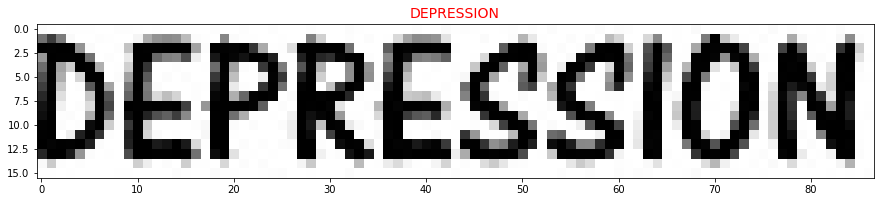

In [17]:


image = load_image(get_path_project_dir('example/manga_annotated/normal_01.jpg'))

localization_model = 
lines = localization_model.locate_lines(image)

show_images(
    [dataset_example.get_line_image(0)],
    [model.recognize(dataset_example.get_line_image(0), device=device)],
) 



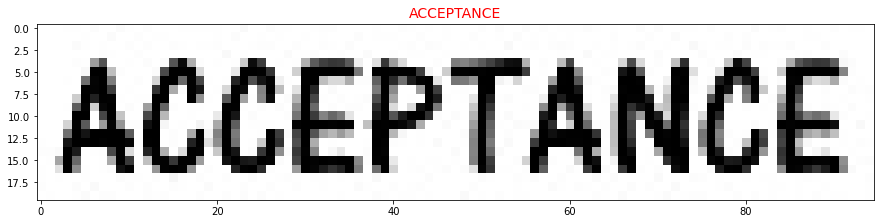

In [20]:
show_images(
    [dataset_example.get_line_image(1)],
    [model.recognize(dataset_example.get_line_image(1), device=device)],
) 

In [21]:
torch.save(model.cpu(), model_path)

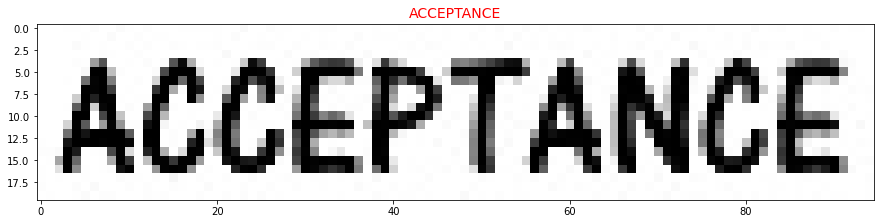

In [22]:
show_images(
    [dataset_example.get_line_image(1)],
    [model.recognize(dataset_example.get_line_image(1), device='cpu')],
) 